In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
from template_funciones import *

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [5]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

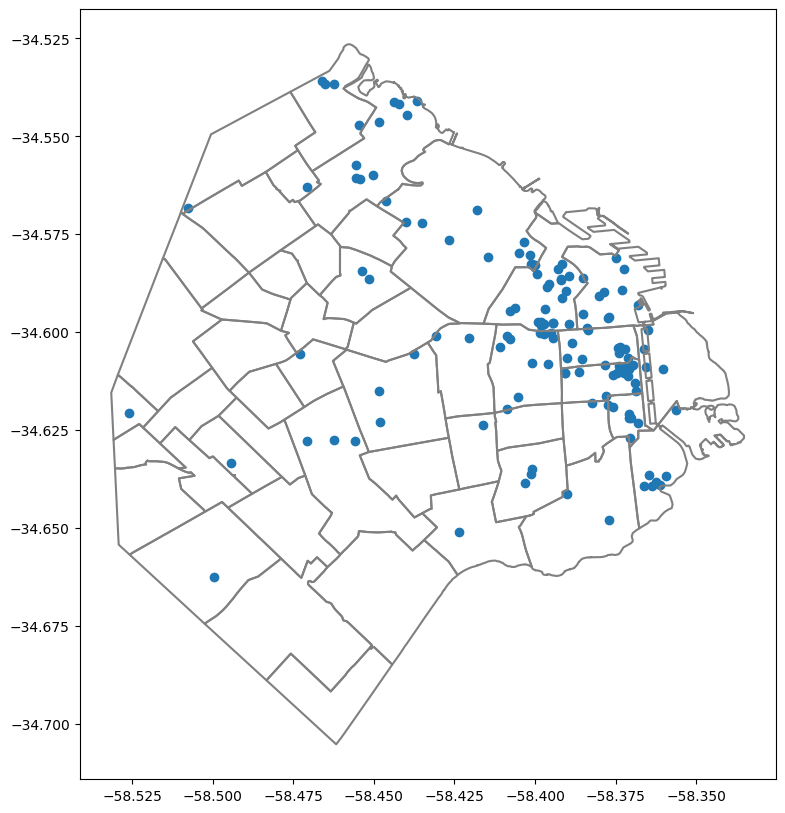

In [6]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [7]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [8]:
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [9]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

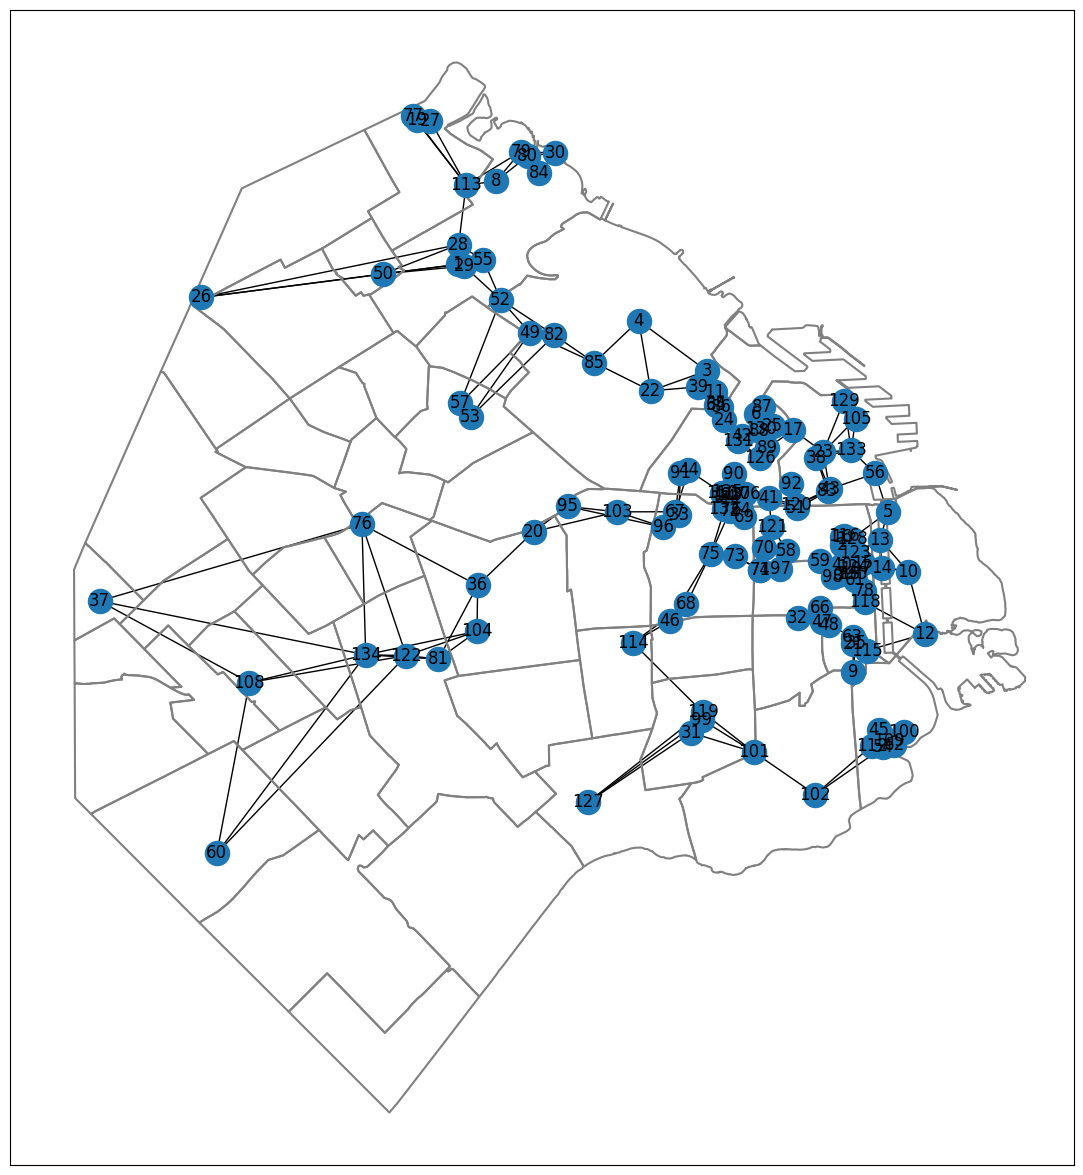

In [10]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Partiendo de la definicion de p
$$
p = (1-\alpha)Cp + \frac{\alpha}{N}\textbf{1} \\
p - (1-\alpha)Cp = \frac{\alpha}{N}\textbf{1} \\
(I + (1-\alpha)C)p = \frac{\alpha}{N}\textbf{1}\\
\frac{N}{\alpha}(I + (1-\alpha)C)p = \textbf{1}\\
Mp = \textbf{1} = b\\
$$
Se llega al sistema. Por lo tanto p es solucion del sistema por su definicion.

## Punto 2:


Para que la ecuación del punto anterior tenga una única solucion, la matriz M debe ser invertible. Para que M sea invertible su determinante debe ser distinto de 0. $ det(M) \neq 0 $

Usamos la  propiedad del determinante: $det(kA)=k^n det(A)$ donde $k$ es un escalar y $n$ es la dimensión de la matriz.

Por lo tanto:

$det(M) = det(\frac{N}{\alpha}(I-(1-\alpha)C))=(\frac{N}{\alpha})^N det(I-(1-\alpha)C)$

$\frac{N}{\alpha}$ es un escalar positivo, ya que $N > 0$ y $0 < \alpha < 1$, $det(M) \neq 0$ si y solo si $det(I - (1-\alpha)C)\neq 0$.

Probar que el determinante no es nulo es equivalente a probar si la matriz es inversible, así que ahora vamos a probar si la matriz $I - (1-\alpha)C$ es inversible. Sabemos que $C$ es una matriz estocástica por columnas, por lo que $||C||_1 = 1$ y ya que $0 < \alpha <1$ entonces $0 < (1 - \alpha) < 1$. Llamo $\beta$ a $1-\alpha$. Con esto podemos decir que $0 < ||\beta C||_1 < 1$ ya que $||\beta C||_1 = |\beta|·||C||_1$ y $|\beta| = \beta$ porque $\beta > 0$.
  
Ahora vamos a probar que la matriz $I - \beta C$ es inversible debido a que $||\beta C||_1 < 1$.

Si no fuera inversible, existiría un vector no nulo x tal que: 

$(I - \beta C)x = 0 \implies x - (\beta C)x = 0 \implies x = (\beta C)x \implies ||x||_1 = ||(\beta C)x||_1$

Por la propiedad submultiplicativa de las normas matriciales:

$||(\beta C)x||_1 \leq ||x||_1 · ||(\beta C)||_1$

y ya que $||x||_1 = ||(\beta C)x||_1$ entonces:

$||x||_1 \leq ||x||_1 · ||(\beta C)||_1 \implies 1 \leq ||(\beta C)||_1$

Lo cual es un absurdo ya que partimos de la hipótesis de que $||(\beta C)||_1 < 1$.

Por lo que $(I - \beta C)$ debe ser inversible lo que implica que $det(I - (1-\alpha)C)\neq 0$.

## Punto 3:

Para calcular los rankings, primero queremos hacer una función para calcular la matriz de grados $K$.

La función construir_matriz_grado toma como parametro de entrada la matriz de adyacencias $A$ que construimos a partir de leer los datos de los museos y calculando sus distancias y retorna la matriz de grados $K$ donde
$$K_{ij} = \begin{cases} 
\sum^{N}_{h=1} A_{ih}, \qquad i=j \\
0, \qquad \qquad \quad i\neq j


\end{cases}$$

Calculamos la inversa $K^{-1}$ resolviendo el sistema triangular $(K|I)$.

La función inversa_de_triangular toma como entrada una matriz triangular $M$ y resuelve el sistema $(M|I)$.

Ahora creamos la matriz de transiciones $C = A^T K^{-1}$.

La función crear_matriz_transiciones toma dos matrices $A, K^{-1}$ y retorna el producto entre la transpuesta de $A$ y $K^{-1}$.

Finalmente la solución al sistema $M\textbf{p}=\textbf{b}$ con $\textbf{b} = \textbf{1}$ será la matriz de puntajes.

La función toma una matriz de transiciones $C$, construye la matriz $M=\frac{N}{\alpha}(I-(1-\alpha)C)$ y retorna la solución al sistema $M\textbf{p}=\textbf{b}$ con $\textbf{b} = \textbf{1}$ utilizando descomposición LU.

Encapsulamos todo en una única función que calcula el puntaje para cada museo.

### 3.a 

Construimos la red conectando a cada museo con sus $m = 3$ vecino más cercanos y procedemos a graficar la red asignando un tamaño proporcional a cada nodo según su Page Rank, para ello utilizamos la función calcular_puntajes definida anteriormente. 

In [11]:

Nprincipales = 5 # Cantidad de principales
m = 3 # Cantidad de vecinos mas cercanos
d = 1/5 # factor de dumping
pr = calcular_p(D, m, d)

# identificar museos mas centrales
principales = np.argsort(pr)[-3:]
print(principales)

[ 18 125 117]


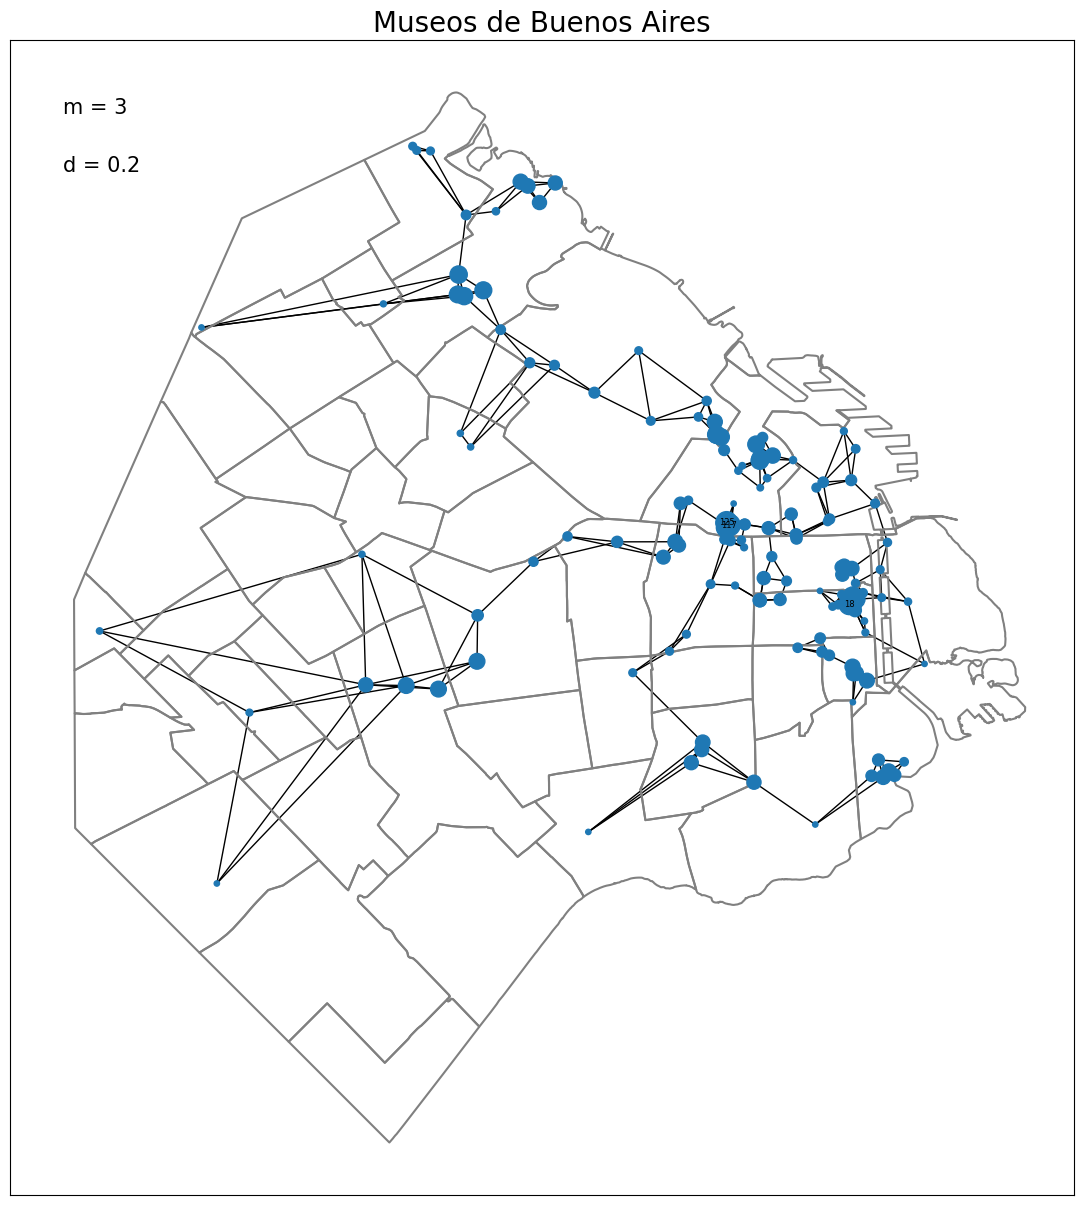

In [12]:
graficar_red_p(pr, A, m, d, museos, barrios, Nprincipales=3)

### 3.b) m = 1, 3, 5, 10 y usando α = 1/5
TODO: RESPONDER

¿Son estables las posiciones en el ranking? Describa los distintos patrones que observa,
identificando que ubicaciones son relevantes encada caso. 
¿Hay museos que solo son relevantes en redes con pocas conexiones?
¿O museos que se vuelven mas relevantes mientras mas conexiones aparecen?

¿Que regiones se vuelven mas predominantes al aumentar α? ¿Y al aumentar m?

In [13]:
ms = [1, 3, 5, 10] 
d = 1/5
ps = [] # Lista de scores page rank para cada m y d
for m in ms:
    pr = calcular_p(D, m, d)
    ps.append(pr)

In [14]:
museos.columns
print(museos.loc[0,'name'])

Manzana de las Luces


Museo Nacional de Arte Oriental
Museo Nacional de Arte Decorativo
Museo Franciscano
Museo del antiguo recinto del Congreso Nacional
Museo Casa Rosada
Museo de la Ciudad
Museo de Odontología
Museo de Farmacobotánica
Museo Histórico de la AFIP
Museo de la Facultad de Odontología
[ 65  34 135 107  15  18  93 117 124 125]


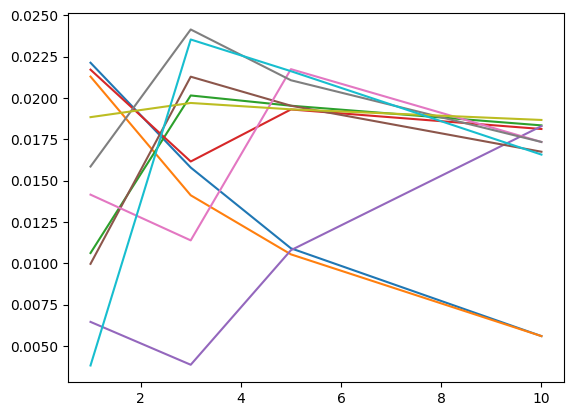

In [15]:
# TODO: Agregar los axis, labels de cada museo. Hacer lo mismo para el C.
tres_principales_cada_m = []
for i, p in enumerate(ps):
    principales = np.argsort(p)[-3:]
    tres_principales_cada_m.append(principales)


tres_principales_cada_m = np.array(list(set(np.hstack(tres_principales_cada_m))))
for X in tres_principales_cada_m:
    print(museos.loc[X, 'name'])
print(tres_principales_cada_m)

for i, p in enumerate(ps):
    ps[i] = ps[i][tres_principales_cada_m]
plt.plot(ms, ps)

ValueError: s must be a scalar, or float array-like with the same size as x and y

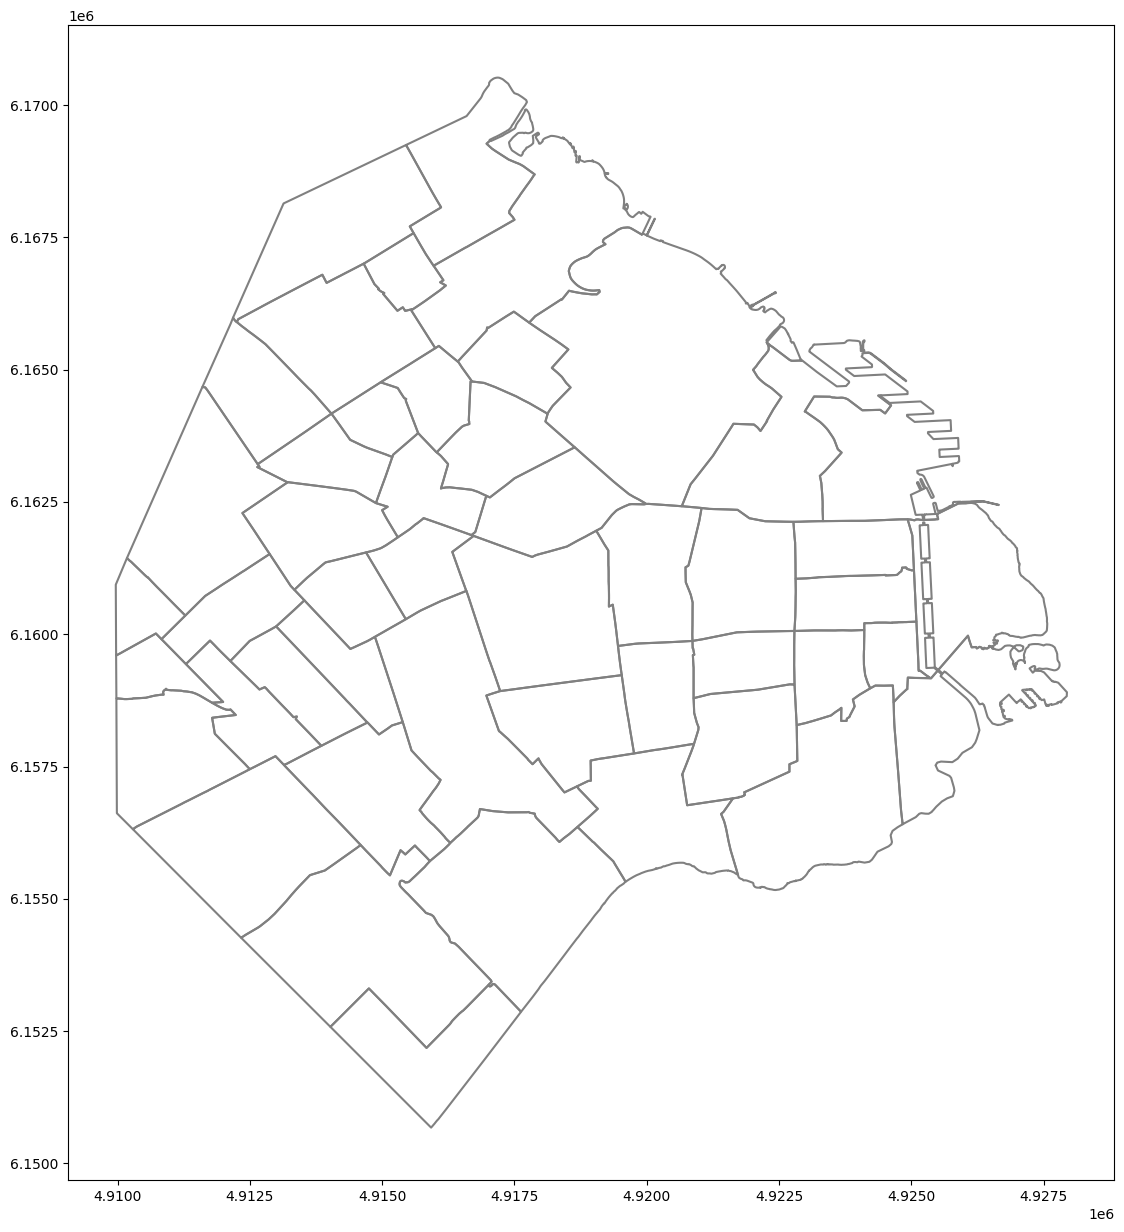

In [16]:
# Mapas para cada par m, d
for i, p in enumerate(ps):
    graficar_red_p(p, A, ms[i], d, museos, barrios, Nprincipales=3)
    

### 3.c) m = 5 y α = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7

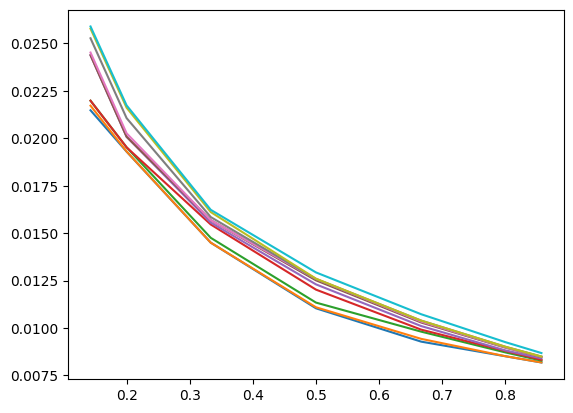

In [17]:
m = 5
ds = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
ps = []
for d in ds:
    pr = calcular_p(D, m, d)
    principales = np.argsort(pr)[-10:]
    ps.append(pr[principales])
    # pr = calcular_p(D, m, d)
    # # identificar museos mas centrales
    # principales = np.argsort(pr)[-3:]
    # print(principales)
    # graficar_red_p(pr, A, m, d, museos, barrios, Nprincipales=3)

plt.plot(ds, ps)

## Punto 4:

## Punto 5:

Nos piden calcular la cantidad total de visitantes que entraron en la red, es decir $||v||_1$ utilizando la ecuación del punto 4.
$$\textbf{v} = B^{-1} \textbf{w}$$

Para esto, creamos la función calcula_matriz_C_continua que recibe la matriz de distancias $D$ y calcula $C$ donde
$$C_{ij}= \frac{f(d_{ij})}{\sum^{N}_{k=1,k\neq i}f(d_{ik})}$$

y la función calcula_B que toma la matriz $C$ y el número de pasos $r$ y retorna la matriz $B$ donde $$B = \sum^{r-1}_{k=0} C^k$$

Armamos una función calcular_norma_v que recibe como parametros el vector $\textbf{w}$ y la matriz de adyacencias $A$ para encontrar $\textbf{v}$ y retornar su norma.

In [26]:
# construimos el vector w con los datos de visitas.txt
w = np.loadtxt("visitas.txt", dtype=int)
# cantidad de visitas
r = 3



def calcular_norma_v(A, w):
    C = calcula_matriz_C_continua(A)
    B = calcula_B(C, r)
    L, U = calculaLU(B) # Calculamos descomposición LU a partir de B

    Uv = scipy.linalg.solve_triangular(L,w,lower=True)
    v = scipy.linalg.solve_triangular(U,Uv)

    return np.linalg.norm(v, ord=1)

print(calcular_norma_v(D, w))


0
1
50330.93036829439


## Punto 6:

In [33]:
C = calcula_matriz_C_continua(D)
B = calcula_B(C, 3)

cond = np.linalg.cond(B)

print("Cond(B): ", cond)
print("Cota: ", cond * 0.05)

0
1
Cond(B):  4.2042320607658645
Cota:  0.21021160303829323


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres